In [1]:
import folium
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from math import pi, cos
from dataclasses import dataclass
from loguru import logger

from plot import ecdf
from geogiant.common.files_utils import load_pickle, load_csv, load_json
from geogiant.common.settings import PathSettings, ClickhouseSettings

path_settings = PathSettings()
clickhouse_settings = ClickhouseSettings()


@dataclass(frozen=True)
class TargetScores:
    """
    dataclass object for storing a given score methodology.
    Score depends on the set of selected hostnames.
    """

    score_config: dict
    hostnames: list[str]
    cdns: list[str]
    score_answers: dict[list]
    score_answer_subnets: dict[list]
    score_answer_bgp_prefixes: dict[list]


@dataclass(frozen=True)
class EvalResults:
    """
    dataclass object for storing a given results methodology.
    Results depends on score calculation.
    """

    target_scores: TargetScores
    results_answers: list[dict]
    results_answer_subnets: list[dict]
    results_answer_bgp_prefixes: list[dict]


def get_median_dist_error(target_results: dict, key: str) -> float:
    """return the median distance error"""
    return round(
        np.median([r[key]["d_error"] for r in target_results.values()]),
        2,
    )


def get_median_rtt_error(target_results: dict, key: str) -> float:
    """return the median distance error"""
    return round(
        np.median([r[key]["rtt"] for r in target_results.values()]),
        2,
    )

In [2]:
ref_shortest_ping_results = load_pickle(
    path_settings.RESULTS_PATH / "results_ref_shortest_ping.pickle"
)

In [3]:
def plot_results() -> None:
    fig, ax1 = plt.subplots(1, 1)

    eval_dir = path_settings.RESULTS_PATH / "tier2_evaluation"

    eval_files = []
    for file in eval_dir.iterdir():
        if "result" in file.name:
            eval_files.append(file.name)

    for file in eval_files:

        print(file)

        eval: EvalResults = load_pickle(
            path_settings.RESULTS_PATH / f"tier2_evaluation/{file}"
        )

        ref_shortest_ping_m_d = get_median_dist_error(
            ref_shortest_ping_results, "ref_shortest_ping_vp"
        )

        results_answer_subnet = eval.results_answer_subnets

        score_config = eval.target_scores.score_config

        total_hostnames = set()
        for cdn, hostnames in score_config["hostname_per_cdn"].items():
            logger.info(f"CDN:: {cdn}, {len(hostnames)} hostnames selected")
            total_hostnames.update(hostnames)

        logger.info(f"{len(total_hostnames)=}")
        logger.info(f"nb targets:: {len(results_answer_subnet)}")

        d_error_per_budget = defaultdict(dict)
        for target, target_results_per_metric in results_answer_subnet.items():
            for metric, target_results in target_results_per_metric[
                "result_per_metric"
            ].items():
                if not metric in ["jaccard"]:
                    continue
                for budget, ecs_shortest_ping_vp in target_results[
                    "ecs_shortest_ping_vp_per_budget"
                ].items():
                    try:
                        d_error_per_budget[metric][budget].append(
                            ecs_shortest_ping_vp["d_error"]
                        )
                    except KeyError:
                        d_error_per_budget[metric][budget] = [
                            ecs_shortest_ping_vp["d_error"]
                        ]

        for metric in d_error_per_budget:
            for budget, d_errors in d_error_per_budget[metric].items():
                if budget in [50]:
                    x, y = ecdf([d for d in d_errors])
                    m_error = round(np.median(d_errors), 2)
                    ax1.plot(
                        x,
                        y,
                        label=f"ECS shortest ping, {metric}, {budget} VPs, {len(eval.target_scores.hostnames)}",
                    )

                    logger.info(
                        f"ECS shortest ping:: {metric}, {budget} VPs, median_error={round(m_error, 2)} [km], {len(eval.target_scores.hostnames)} hostnames"
                    )

        no_ping_per_metric = defaultdict(list)
        for target, target_results_per_metric in results_answer_subnet.items():
            for metric, target_results in target_results_per_metric[
                "result_per_metric"
            ].items():
                no_ping_per_metric[metric].append(
                    target_results["no_ping_vp"]["d_error"]
                )

        for metric, cdf in no_ping_per_metric.items():
            x, y = ecdf([r for r in cdf])
            ax1.plot(
                x, y, label=f"Zero ping, {metric}, {len(eval.target_scores.hostnames)}"
            )
            m_error = round(
                np.median([r for r in cdf]),
                2,
            )

            logger.info(f"Zero ping:: {metric}, median_error={round(m_error, 2)} [km]")

        logger.info("###############################")

    ref_shortest_ping_m_d = get_median_dist_error(
        ref_shortest_ping_results, "ref_shortest_ping_vp"
    )

    x, y = ecdf(
        [
            r["ref_shortest_ping_vp"]["d_error"]
            for r in ref_shortest_ping_results.values()
        ]
    )
    ax1.plot(x, y, label=f"Reference shortest ping")

    logger.info(
        f"Reference shortest ping:: median_error={round(ref_shortest_ping_m_d, 2)} [km]"
    )

    plt.xlabel("geolocation error [km]")
    plt.ylabel("proportion of targets")
    plt.legend(loc="upper left", fontsize=8)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xscale("log")
    plt.grid()
    plt.title(
        f"CDF: Geolocation error",
        fontsize=13,
    )
    plt.savefig(path_settings.FIGURE_PATH / f"tier2_geoloc_error_7_CDNS.pdf")
    plt.show()

# AMAZON / AWSDNS eval

results__10_hostname_7_dns_ns.pickle


2024-04-23 17:46:54.326 | INFO     | __main__:plot_results:29 - CDN:: AMAZON, 10 hostnames selected
2024-04-23 17:46:54.328 | INFO     | __main__:plot_results:29 - CDN:: GOOGLE, 10 hostnames selected
2024-04-23 17:46:54.329 | INFO     | __main__:plot_results:29 - CDN:: CDN77, 10 hostnames selected
2024-04-23 17:46:54.331 | INFO     | __main__:plot_results:29 - CDN:: AKAMAI, 10 hostnames selected
2024-04-23 17:46:54.332 | INFO     | __main__:plot_results:29 - CDN:: INCAPSULA, 10 hostnames selected
2024-04-23 17:46:54.333 | INFO     | __main__:plot_results:29 - CDN:: AS-HOSTINGER, 10 hostnames selected
2024-04-23 17:46:54.334 | INFO     | __main__:plot_results:29 - CDN:: FACEBOOK, 10 hostnames selected
2024-04-23 17:46:54.335 | INFO     | __main__:plot_results:32 - len(total_hostnames)=70
2024-04-23 17:46:54.336 | INFO     | __main__:plot_results:33 - nb targets:: 759
2024-04-23 17:46:54.346 | INFO     | __main__:plot_results:65 - ECS shortest ping:: jaccard, 50 VPs, median_error=8.9 [km

results__100_hostname_7_dns_ns.pickle


2024-04-23 17:46:54.692 | INFO     | __main__:plot_results:29 - CDN:: AMAZON, 100 hostnames selected
2024-04-23 17:46:54.694 | INFO     | __main__:plot_results:29 - CDN:: GOOGLE, 100 hostnames selected
2024-04-23 17:46:54.695 | INFO     | __main__:plot_results:29 - CDN:: CDN77, 24 hostnames selected
2024-04-23 17:46:54.696 | INFO     | __main__:plot_results:29 - CDN:: AKAMAI, 100 hostnames selected
2024-04-23 17:46:54.697 | INFO     | __main__:plot_results:29 - CDN:: INCAPSULA, 100 hostnames selected
2024-04-23 17:46:54.698 | INFO     | __main__:plot_results:29 - CDN:: AS-HOSTINGER, 100 hostnames selected
2024-04-23 17:46:54.700 | INFO     | __main__:plot_results:29 - CDN:: FACEBOOK, 91 hostnames selected
2024-04-23 17:46:54.701 | INFO     | __main__:plot_results:32 - len(total_hostnames)=615
2024-04-23 17:46:54.702 | INFO     | __main__:plot_results:33 - nb targets:: 759
2024-04-23 17:46:54.707 | INFO     | __main__:plot_results:65 - ECS shortest ping:: jaccard, 50 VPs, median_error=8

results__1_hostname_7_dns_ns.pickle


2024-04-23 17:46:54.986 | INFO     | __main__:plot_results:29 - CDN:: AMAZON, 1 hostnames selected
2024-04-23 17:46:54.988 | INFO     | __main__:plot_results:29 - CDN:: GOOGLE, 1 hostnames selected
2024-04-23 17:46:54.992 | INFO     | __main__:plot_results:29 - CDN:: CDN77, 1 hostnames selected
2024-04-23 17:46:54.994 | INFO     | __main__:plot_results:29 - CDN:: AKAMAI, 1 hostnames selected
2024-04-23 17:46:54.995 | INFO     | __main__:plot_results:29 - CDN:: INCAPSULA, 1 hostnames selected
2024-04-23 17:46:54.997 | INFO     | __main__:plot_results:29 - CDN:: AS-HOSTINGER, 1 hostnames selected
2024-04-23 17:46:54.998 | INFO     | __main__:plot_results:29 - CDN:: FACEBOOK, 1 hostnames selected
2024-04-23 17:46:55.000 | INFO     | __main__:plot_results:32 - len(total_hostnames)=7
2024-04-23 17:46:55.001 | INFO     | __main__:plot_results:33 - nb targets:: 759
2024-04-23 17:46:55.009 | INFO     | __main__:plot_results:65 - ECS shortest ping:: jaccard, 50 VPs, median_error=12.2 [km], 7 ho

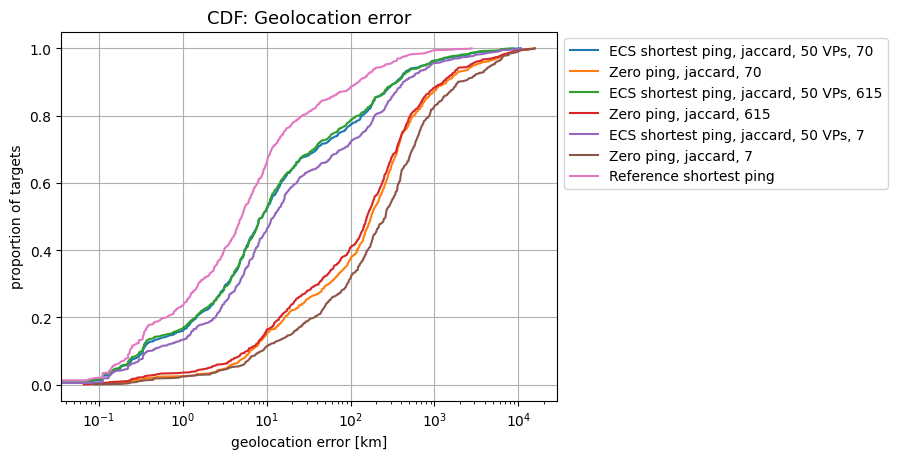

In [4]:
plot_results()